In [107]:
import tensorflow as tf
from tensorflow.keras.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from hausdorff import hausdorff_distance
#import lr_scheduler
from tensorflow.keras.regularizers import l2

import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.morphology import label
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

In [108]:
TRAIN_PATH="DRIVE/training/"
TEST_PATH="DRIVE/test/"

In [109]:
train_ids=next(os.walk(TRAIN_PATH+'images/'))[2][:]
test_ids=next(os.walk(TEST_PATH+'images/'))[2][:]
print(len(train_ids))

20


In [110]:
input_height = IMG_HEIGHT = 256
input_width = IMG_WIDTH = 256
IMG_CHANNELS = 3

In [111]:

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TRAIN_PATH + 'mask/' + id_[:-4] + '_mask.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_train[n][mask > 0.] = 1.

print('Resizing test images and masks')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):   
    path = TEST_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TEST_PATH + 'mask/' + id_[:-4] + '_mask.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_test[n][mask > 0.] = 1.

Resizing training images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_31268\727015007.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.49it/s]


Resizing test images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_31268\727015007.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.74it/s]


In [112]:
print(X_train.shape, Y_test.shape)

(20, 256, 256, 3) (20, 256, 256, 1)


C:\Users\manda\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


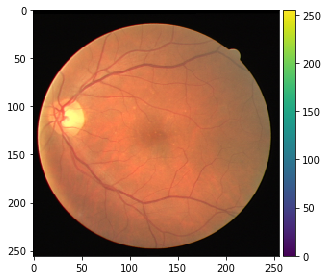

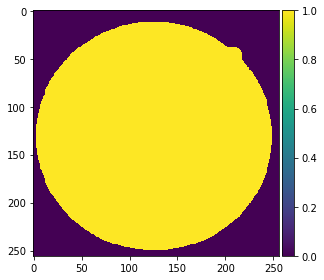

In [113]:
ix=0
imshow(X_train[ix].astype('int'))
plt.show()
imshow(np.squeeze(Y_train[ix].astype('int')))
plt.show()

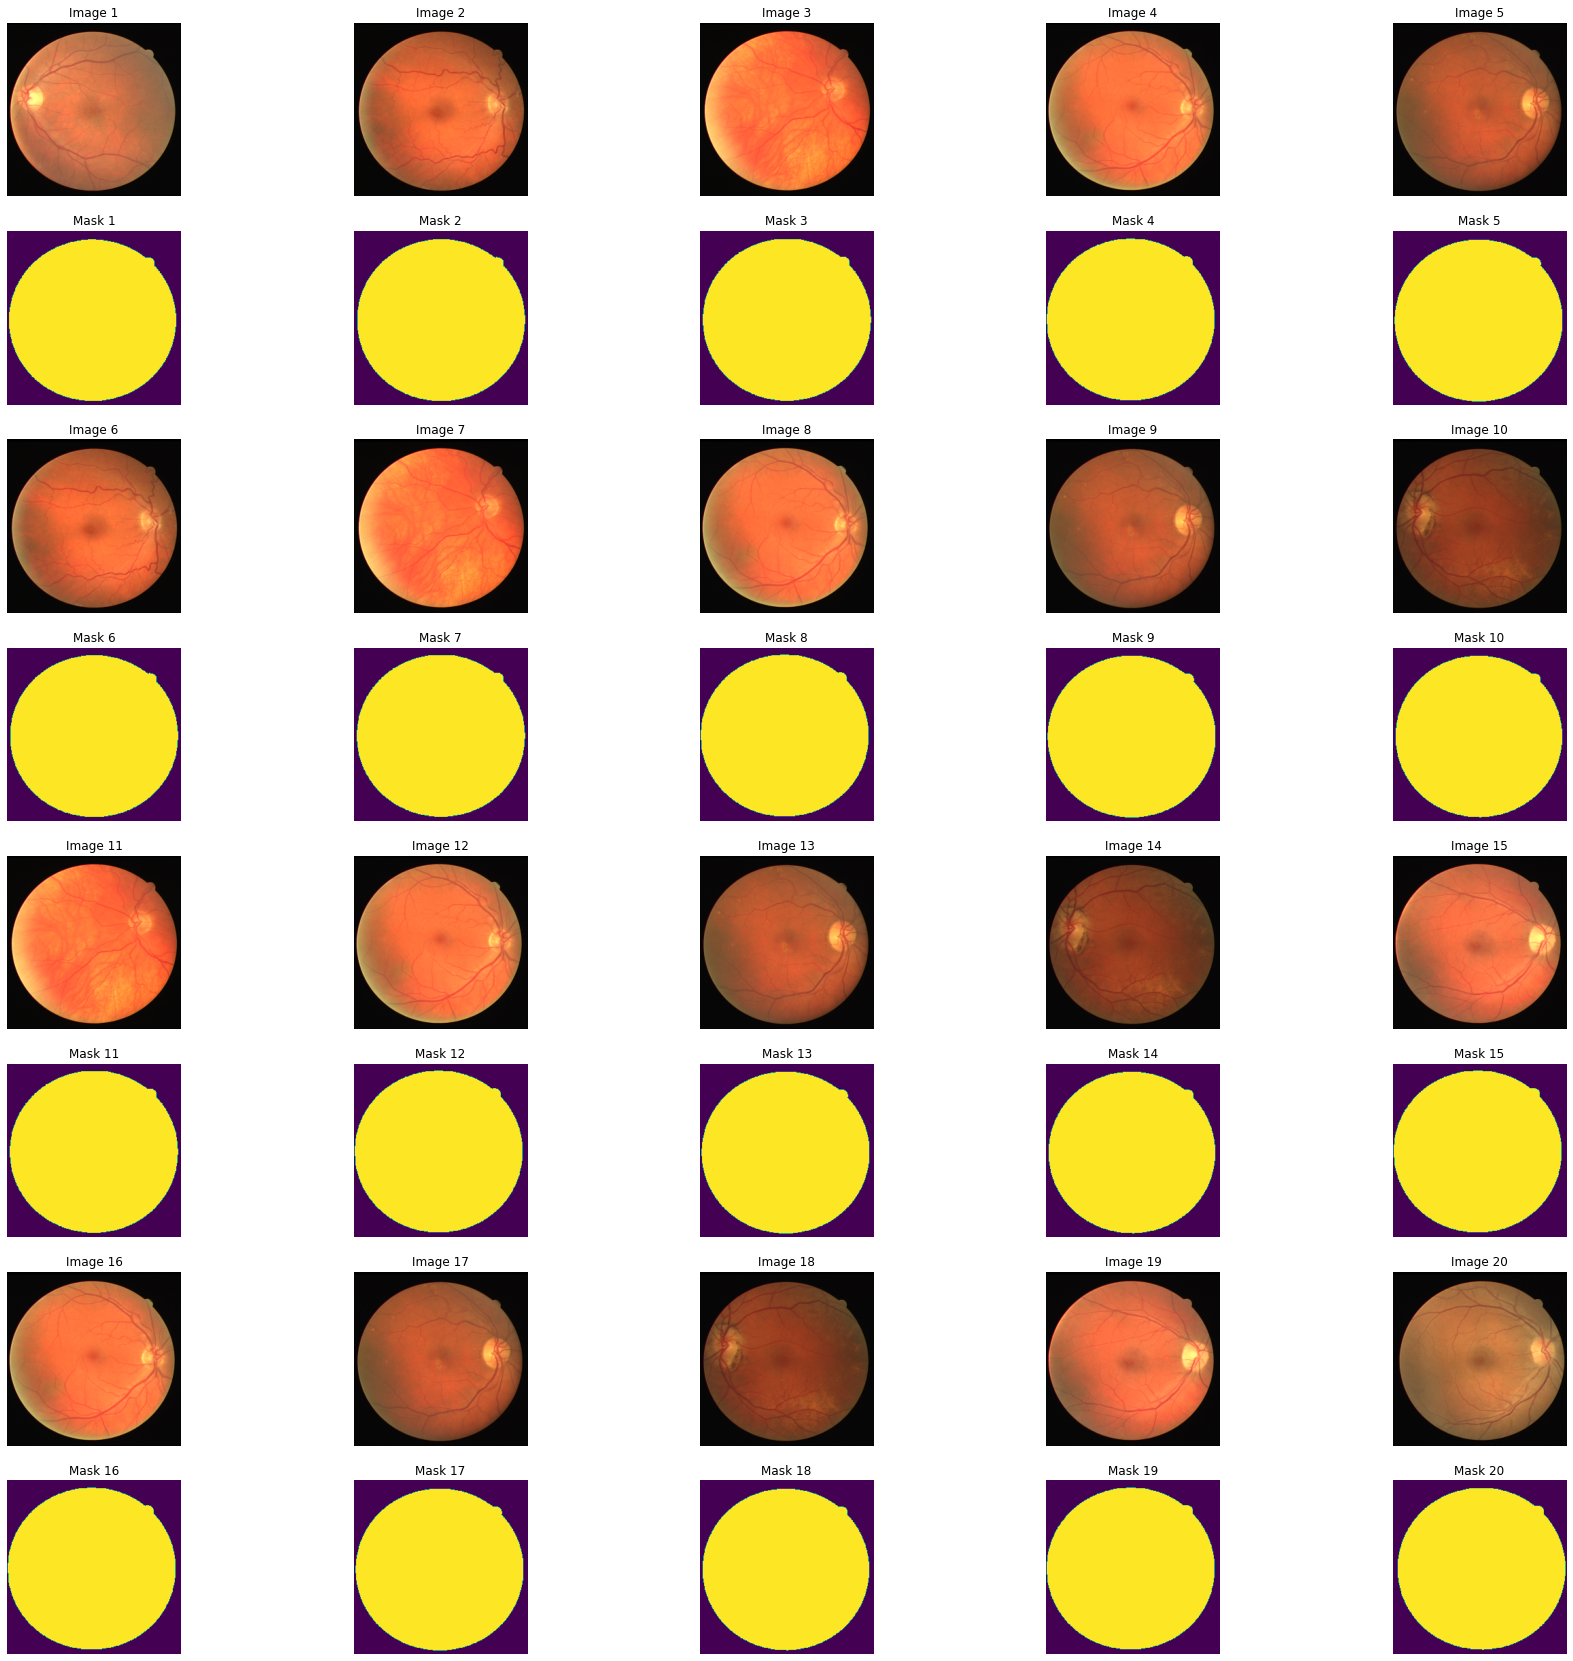

In [114]:
plt.figure(figsize=(30,30))
x, y = 5, 4
count=1
for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i+j
        plt.imshow(X_train[pos].astype('int'))
        plt.title('Image {}'.format(count))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos].astype('int')))
        plt.title('Mask {}'.format(count))
        plt.axis('off')
        count = count + 1
plt.show()

In [115]:
def expend_as(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    axis = 3
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=axis)(shortcut)

    res_path = add([shortcut, conv])
    return res_path

def encoder(inputs):
    num_filters = [16, 32, 64, 128]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        a = double_conv_layer(x, 3, f, 0.1, True)
        skip_connections.append(a)
        x = MaxPooling2D(pool_size=(2, 2))(a)
    
    return x, skip_connections

def bottleneck(inputs):
    x = inputs
    f = 256
    
    x3 = double_conv_layer(x, 3, f, 0.1, True)
    
    return x3

def decoder(inputs, skip_connections):
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs
    batch_norm = True
    
    for i, f in enumerate(num_filters):
        
        x_up = UpSampling2D(size=(2, 2), data_format="channels_last")(x)
        x_att = concatenate([x_up, skip_connections[i]], axis=-1)
        
        x = double_conv_layer(x_att, 3, f, 0.1, True)
    return x

def output(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    return x

In [116]:
def random_resize_crop(image, scale=[0.75, 1.0], crop_size=128):
    if crop_size == 32:
        image_shape = 48
        image = tf.image.resize(image, (image_shape, image_shape))
    else:
        image_shape = 96
        image = tf.image.resize(image, (image_shape, image_shape))
    size = tf.random.uniform(
        shape=(1,),
        minval=scale[0] * image_shape,
        maxval=scale[1] * image_shape,
        dtype=tf.float32,
    )
    size = tf.cast(size, tf.int32)[0]
    crop = tf.image.random_crop(image, (size, size, 3))
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))
    return crop_resize

def flip_random_crop(image):
    image = tf.image.random_flip_left_right(image)
    image = random_resize_crop(image, crop_size=CROP_TO)
    return image


@tf.function
def float_parameter(level, maxval):
    return tf.cast(level * maxval / 10.0, tf.float32)


@tf.function
def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)

def rotation(image):
    augmented_image = tf.image.rot90(image)
    return augmented_image

@tf.function
def solarize(image, level=6):
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 255 - image)

def color_jitter(x, strength=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength)
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength)
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    image = tf.cast(image, tf.float32)
    image = flip_random_crop(image)
    image = random_apply(rotation, image, p=0.5)
    #image = random_apply(color_jitter, image, p=0.9)
    #image = random_apply(color_drop, image, p=0.3)
    #image = random_apply(solarize, image, p=0.3)
    return image

In [117]:
AUTO = tf.data.AUTOTUNE
CROP_TO = IMG_HEIGHT
SEED = 42
BATCH_SIZE = 4
ssl_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

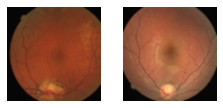

In [118]:
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    #print(sample_images_one[n].numpy().shape)
    plt.axis("off")
plt.show()

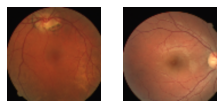

In [119]:
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [120]:
def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1]
    off_diagonals = tf.reshape(flattened, (n-1, n+1))[:, 1:]
    return tf.reshape(off_diagonals, [-1])


def normalize_repr(z):
    z_norm = (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)
    return z_norm


def compute_loss(z_a, z_b, lambd):
    # Get batch size and representation dimension.
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    repr_dim = tf.shape(z_a)[1]

    # Normalize the representations along the batch dimension.
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)

    # Cross-correlation matrix.
    c = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / batch_size

    # Loss.
    on_diag = tf.linalg.diag_part(c) + (-1)
    on_diag = tf.reduce_sum(tf.pow(on_diag, 2))
    off_diag = off_diagonal(c)
    off_diag = tf.reduce_sum(tf.pow(off_diag, 2))
    loss = on_diag + (lambd * off_diag)
    return loss 

In [121]:
class BarlowTwins(tf.keras.Model):
    def __init__(self, encoder, lambd=5e-3):
        super(BarlowTwins, self).__init__()
        self.encoder = encoder
        self.lambd = lambd
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z_a, z_b = self.encoder(ds_one, training=True), self.encoder(ds_two, training=True)
            loss = compute_loss(z_a, z_b, self.lambd) 

        # Compute gradients and update the parameters.
        gradients = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [122]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Implements an LR scheduler that warms up the learning rate for some training steps
    (usually at the beginning of the training) and then decays it
    with CosineDecay (see https://arxiv.org/abs/1608.03983)
    """

    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [123]:
PROJECT_DIM = IMG_HEIGHT/2
BATCH_SIZE = 8
EPOCHS = 100
WEIGHT_DECAY = 5e-4
TRAIN_FLG = 1 # 0 - No Training, 1 - Training
val_split = 0.3

STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

lr_decayed_fn = WarmUpCosine(
    learning_rate_base=1e-3,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

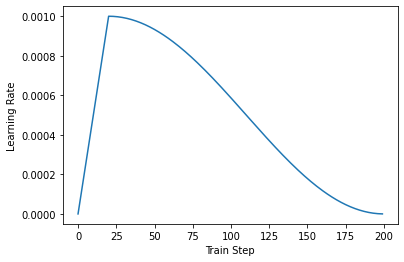

In [124]:
# Visualize the LR schedule
plt.plot(lr_decayed_fn(tf.range(EPOCHS*STEPS_PER_EPOCH, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [125]:
def projection_head(x, hidden_dim=128):
    """Constructs the projection head."""
    for i in range(2):
        x = Dense(
            hidden_dim,
            name=f"projection_layer_{i}",
            kernel_regularizer=l2(WEIGHT_DECAY),
        )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    outputs = Dense(hidden_dim, name="projection_output")(x)
    return outputs

def build_encoder(shape, hidden_dim=128):
    inputs = Input(shape)
    s = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    #s = inputs
    x, skip_1 = encoder(s)
    
    x = bottleneck(x)
    
    # Projections
    trunk_output = GlobalAvgPool2D()(x)
    projection_outputs = projection_head(trunk_output, hidden_dim=hidden_dim)

    model = Model(inputs, projection_outputs)
    return model, skip_1

In [126]:
unet_enc, skip_connetions = build_encoder((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), hidden_dim=PROJECT_DIM)
unet_enc.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 256, 256, 3)  0           ['input_4[0][0]']                
                                                                                                  
 separable_conv2d_54 (Separable  (None, 256, 256, 16  91         ['rescaling_3[0][0]']            
 Conv2D)                        )                                                                 
                                                                                            

 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_97 (BatchN  (None, 64, 64, 64)  256         ['separable_conv2d_59[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 conv2d_32 (Conv2D)             (None, 64, 64, 64)   2112        ['max_pooling2d_13[0][0]']       
                                                                                                  
 activation_68 (Activation)     (None, 64, 64, 64)   0           ['batch_normalization_97[0][0]'] 
                                                                                                  
 batch_normalization_98 (BatchN  (None, 64, 64, 64)  256         ['conv2d_32[0][0]']              
 ormalizat

                                                                                                  
 activation_73 (Activation)     (None, 128)          0           ['batch_normalization_105[0][0]']
                                                                                                  
 projection_layer_1 (Dense)     (None, 128)          16512       ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_106 (Batch  (None, 128)         512         ['projection_layer_1[0][0]']     
 Normalization)                                                                                   
                                                                                                  
 activation_74 (Activation)     (None, 128)          0           ['batch_normalization_106[0][0]']
                                                                                                  
 projectio

Training
Epoch 1/100
5/5 [==============================] - 10s 771ms/step - loss: 56.4173
Epoch 2/100
5/5 [==============================] - 4s 808ms/step - loss: 41.7347
Epoch 3/100
5/5 [==============================] - 5s 959ms/step - loss: 43.8532
Epoch 4/100
5/5 [==============================] - 5s 1s/step - loss: 34.8836
Epoch 5/100
5/5 [==============================] - 5s 914ms/step - loss: 30.4782
Epoch 6/100
5/5 [==============================] - 4s 853ms/step - loss: 40.8437
Epoch 7/100
5/5 [==============================] - 4s 859ms/step - loss: 31.5105
Epoch 8/100
5/5 [==============================] - 4s 848ms/step - loss: 52.9377
Epoch 9/100
5/5 [==============================] - 4s 874ms/step - loss: 34.8587
Epoch 10/100
5/5 [==============================] - 5s 893ms/step - loss: 40.5136
Epoch 11/100
5/5 [==============================] - 4s 846ms/step - loss: 37.6429
Epoch 12/100
5/5 [==============================] - 4s 850ms/step - loss: 35.0429
Epoch 13/100
5/5 [

INFO:tensorflow:Assets written to: barlow_twins_unet\assets


INFO:tensorflow:Assets written to: barlow_twins_unet\assets


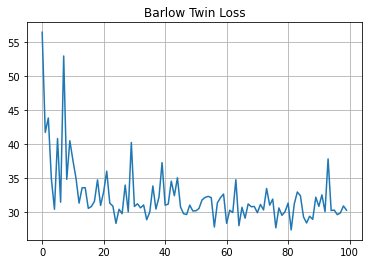

In [127]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
barlow_twins = BarlowTwins(unet_enc)
barlow_twins.compile(optimizer=optimizer)
if TRAIN_FLG:
    print("Training")
    barlow_twins.encoder.get_weights()[0]
    history = barlow_twins.fit(ssl_ds, epochs=EPOCHS)
    barlow_twins.encoder.save('barlow_twins_unet')
    plt.plot(history.history["loss"])
    plt.grid()
    plt.title("Barlow Twin Loss")
    plt.show()
elif not TRAIN_FLG:
    print("Loading training weights")
    barlow_twins.encoder.load_weights('barlow_twins_unet')

In [128]:
backbone = tf.keras.Model(
    barlow_twins.encoder.input, barlow_twins.encoder.layers[-9].output
)
backbone.layers

In [129]:
backbone.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 256, 256, 3)  0           ['input_4[0][0]']                
                                                                                                  
 separable_conv2d_54 (Separable  (None, 256, 256, 16  91         ['rescaling_3[0][0]']            
 Conv2D)                        )                                                                 
                                                                                           

 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_97 (BatchN  (None, 64, 64, 64)  256         ['separable_conv2d_59[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 conv2d_32 (Conv2D)             (None, 64, 64, 64)   2112        ['max_pooling2d_13[0][0]']       
                                                                                                  
 activation_68 (Activation)     (None, 64, 64, 64)   0           ['batch_normalization_97[0][0]'] 
                                                                                                  
 batch_normalization_98 (BatchN  (None, 64, 64, 64)  256         ['conv2d_32[0][0]']              
 ormalizat

In [130]:
new_skip_connections = [backbone.get_layer(index=11).output, 
                        backbone.get_layer(index=22).output, 
                        backbone.get_layer(index=33).output, 
                        backbone.get_layer(index=44).output]

In [131]:
new_skip_connections

[<KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'add_27')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'add_28')>,
 <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'add_29')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'add_30')>]

In [132]:
backbone.output

<KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'add_31')>

In [133]:
backbone.trainable=True
x = backbone.output
#x = bottleneck(x)
x = decoder(x, new_skip_connections)
outputs = output(x)
model = Model(barlow_twins.encoder.input, outputs)

In [134]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 256, 256, 3)  0           ['input_4[0][0]']                
                                                                                                  
 separable_conv2d_54 (Separable  (None, 256, 256, 16  91         ['rescaling_3[0][0]']            
 Conv2D)                        )                                                                 
                                                                                           

 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_97 (BatchN  (None, 64, 64, 64)  256         ['separable_conv2d_59[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 conv2d_32 (Conv2D)             (None, 64, 64, 64)   2112        ['max_pooling2d_13[0][0]']       
                                                                                                  
 activation_68 (Activation)     (None, 64, 64, 64)   0           ['batch_normalization_97[0][0]'] 
                                                                                                  
 batch_normalization_98 (BatchN  (None, 64, 64, 64)  256         ['conv2d_32[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_107 (Batch  (None, 32, 32, 128)  512        ['separable_conv2d_64[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 activation_75 (Activation)     (None, 32, 32, 128)  0           ['batch_normalization_107[0][0]']
                                                                                                  
 separable_conv2d_65 (Separable  (None, 32, 32, 128)  17664      ['activation_75[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_108 (Batch  (None, 32, 32, 128)  512        ['separable_conv2d_65[0][0]']    
 Normaliza

 batch_normalization_115 (Batch  (None, 128, 128, 32  128        ['conv2d_37[0][0]']              
 Normalization)                 )                                                                 
                                                                                                  
 dropout_34 (Dropout)           (None, 128, 128, 32  0           ['activation_80[0][0]']          
                                )                                                                 
                                                                                                  
 add_34 (Add)                   (None, 128, 128, 32  0           ['batch_normalization_115[0][0]',
                                )                                 'dropout_34[0][0]']             
                                                                                                  
 up_sampling2d_15 (UpSampling2D  (None, 256, 256, 32  0          ['add_34[0][0]']                 
 )        

In [135]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    #print('IOU {}'.format(iou))
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    value = 0.
    for batch in range(batch_size):
        value = value + iou_metric(y_true_in[batch], y_pred_in[batch])
    return value/batch_size

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

def my_iou_metric_loss(label, pred):
    loss = 1-tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    #loss = -tf.map_fn(my_iou_metric_loss(label, pred), tf.range(tf.shape(pred)[0]))
    loss.set_shape((None,))

    return loss

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def haud_dist(y_true, y_pred):
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    return hausdorff_distance(y_true,y_pred)

def haud_dist_batch(y_true, y_pred):
    if len(y_true.shape)==2:
        return haud_dist(y_true, y_pred)
    else:
        batch_size = y_true.shape[0]
    hd = 0.
    for batch in range(batch_size):
        hd = hd + haud_dist(y_true[batch], y_pred[batch])
    return hd/batch_size

def my_haud_dist(label, pred):
    metric_value = tf.py_function(haud_dist_batch, [label, pred], tf.float32)
    return metric_value

def evalResult(gt,pred,target_size=(256,256),flag_multi_class = False,num_class = 2):
    gt = np.squeeze(gt)
    pred = np.squeeze(pred)
    
    acc = Accuracy()
    acc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_acc = acc.result().numpy()
    
    pr = Precision()
    pr.update_state(np.squeeze(gt), np.squeeze(pred))
    r_pr = pr.result().numpy()
    
    rc = Recall()
    rc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_rc = rc.result().numpy()
    
    mi = MeanIoU(num_class)
    mi.update_state(np.squeeze(gt), np.squeeze(pred))
    r_mi = mi.result().numpy()
    
    dc = 0.
    for img in range(gt.shape[0]):
        dc = dc + dice_coeff(gt[img], pred[img]).numpy()
    dc = dc / gt.shape[0]
    
    hd = haud_dist_batch(gt,pred)
    
    miou = iou_metric_batch(gt,pred)
    
    mae = MeanAbsoluteError()
    r_mae = mae(np.squeeze(gt), np.squeeze(pred)).numpy()

    print("Accuracy=",r_acc, "Precision=",r_pr, "Recall=",r_rc, "MeanIoU=",r_mi, "DiceCoefficient=",dc, "HD=",hd, "MyIoU=",miou, "MAE=",r_mae)

In [136]:
def focal_loss(target_tensor, prediction_tensor, weights=None, alpha=0.25, gamma=2):
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.math.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0))                           - (1 - alpha) * (neg_p_sub ** gamma) * tf.math.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

def mean_iou_loss(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return -tf.math.log(K.mean(K.stack(prec), axis=0))

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.4*categorical_crossentropy(y_true, y_pred) + 0.6*dice_loss(y_true, y_pred)
    return loss

def bce_dice_loss2(y_true, y_pred):
    fl = focal_loss(y_true, y_pred, gamma=5)
    loss = 0.2*categorical_crossentropy(y_true, y_pred) + 0.3*dice_loss(y_true, y_pred) + 0.5*fl
    return loss

In [137]:
log_path = "logs/"
keyname = "BT-Unet"
cur_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log_dir = log_path + "fit/" + keyname + '_' + cur_date 
tensorboard_callback = TensorBoard(log_dir=tb_log_dir, histogram_freq=0)
model_checkpoint = ModelCheckpoint('model_'+keyname+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', verbose=1, patience=20)
csv_logger = CSVLogger(log_path + keyname + '_' + cur_date + '.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

In [138]:
model.compile(
    loss=bce_dice_loss,
    optimizer=Adam(),
    metrics=['accuracy', Precision(), MeanIoU(num_classes=2), Recall(), dice_coeff, MeanAbsoluteError(), my_haud_dist, my_iou_metric]
   )
if TRAIN_FLG:
    print("Training")
    callbacks = [
        model_checkpoint,
        reduce_lr,
        csv_logger,
        tensorboard_callback,
        early_stopping
    ]
    X_train_20 = X_train[:int(X_train.shape[0]*0.2)]
    Y_train_20 = Y_train[:int(Y_train.shape[0]*0.2)]
    results = model.fit(X_train_20, Y_train_20, validation_split=val_split, batch_size=8, epochs=200, callbacks=callbacks)
elif not TRAIN_FLG:
    print("Loading training weights")
    model.load_weights('model_'+keyname+'.hdf5')

Training
Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.7865 - precision_6: 0.9998 - mean_io_u_6: 0.1466 - recall_6: 0.6981 - dice_coeff: 0.6973 - mean_absolute_error: 0.3636 - my_haud_dist: 7.1020 - my_iou_metric: 0.0080
Epoch 1: loss improved from inf to 0.18163, saving model to model_BT-Unet.hdf5
1/1 [==============================] - 10s 10s/step - loss: 0.1816 - accuracy: 0.7865 - precision_6: 0.9998 - mean_io_u_6: 0.1466 - recall_6: 0.6981 - dice_coeff: 0.6973 - mean_absolute_error: 0.3636 - my_haud_dist: 7.1020 - my_iou_metric: 0.0080 - val_loss: 0.0324 - val_accuracy: 0.9622 - val_precision_6: 1.0000 - val_mean_io_u_6: 0.1446 - val_recall_6: 0.9468 - val_dice_coeff: 0.9461 - val_mean_absolute_error: 0.0730 - val_my_haud_dist: 2.5980 - val_my_iou_metric: 0.6750 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.8460 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.7821 - dice_coef

Epoch 11/200
1/1 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9673 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9538 - dice_coeff: 0.7494 - mean_absolute_error: 0.3049 - my_haud_dist: 5.6328 - my_iou_metric: 0.7500
Epoch 11: loss improved from 0.15059 to 0.15036, saving model to model_BT-Unet.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.1504 - accuracy: 0.9673 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9538 - dice_coeff: 0.7494 - mean_absolute_error: 0.3049 - my_haud_dist: 5.6328 - my_iou_metric: 0.7500 - val_loss: 0.1156 - val_accuracy: 0.8511 - val_precision_6: 1.0000 - val_mean_io_u_6: 0.1446 - val_recall_6: 0.7905 - val_dice_coeff: 0.8074 - val_mean_absolute_error: 0.2296 - val_my_haud_dist: 6.3970 - val_my_iou_metric: 0.1135 - lr: 0.0010
Epoch 12/200
1/1 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9675 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9540 - dice_coeff: 0

Epoch 21/200
1/1 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9688 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9558 - dice_coeff: 0.7502 - mean_absolute_error: 0.3040 - my_haud_dist: 5.5932 - my_iou_metric: 0.7500
Epoch 21: loss improved from 0.14990 to 0.14988, saving model to model_BT-Unet.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.1499 - accuracy: 0.9688 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9558 - dice_coeff: 0.7502 - mean_absolute_error: 0.3040 - my_haud_dist: 5.5932 - my_iou_metric: 0.7500 - val_loss: 0.1098 - val_accuracy: 0.9236 - val_precision_6: 1.0000 - val_mean_io_u_6: 0.1446 - val_recall_6: 0.8924 - val_dice_coeff: 0.8170 - val_mean_absolute_error: 0.2200 - val_my_haud_dist: 5.5464 - val_my_iou_metric: 0.4652 - lr: 1.0000e-04
Epoch 22/200
1/1 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9687 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9557 - dice_coef

1/1 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9687 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9557 - dice_coeff: 0.7503 - mean_absolute_error: 0.3039 - my_haud_dist: 5.6046 - my_iou_metric: 1.0000
Epoch 31: loss improved from 0.14984 to 0.14983, saving model to model_BT-Unet.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.1498 - accuracy: 0.9687 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9557 - dice_coeff: 0.7503 - mean_absolute_error: 0.3039 - my_haud_dist: 5.6046 - my_iou_metric: 1.0000 - val_loss: 0.1099 - val_accuracy: 0.9494 - val_precision_6: 1.0000 - val_mean_io_u_6: 0.1446 - val_recall_6: 0.9288 - val_dice_coeff: 0.8169 - val_mean_absolute_error: 0.2206 - val_my_haud_dist: 5.2070 - val_my_iou_metric: 0.4846 - lr: 1.0000e-05
Epoch 32/200
1/1 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9684 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9553 - dice_coeff: 0.7502 - m

1/1 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9690 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9562 - dice_coeff: 0.7503 - mean_absolute_error: 0.3038 - my_haud_dist: 5.6287 - my_iou_metric: 0.7500
Epoch 41: loss did not improve from 0.14980
1/1 [==============================] - 1s 1s/step - loss: 0.1498 - accuracy: 0.9690 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9562 - dice_coeff: 0.7503 - mean_absolute_error: 0.3038 - my_haud_dist: 5.6287 - my_iou_metric: 0.7500 - val_loss: 0.1137 - val_accuracy: 0.9573 - val_precision_6: 1.0000 - val_mean_io_u_6: 0.1446 - val_recall_6: 0.9399 - val_dice_coeff: 0.8105 - val_mean_absolute_error: 0.2282 - val_my_haud_dist: 5.1746 - val_my_iou_metric: 0.6750 - lr: 1.0000e-06
Epoch 42/200
1/1 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9688 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9558 - dice_coeff: 0.7503 - mean_absolute_error: 0.3039 - my_haud_dis

1/1 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9690 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9562 - dice_coeff: 0.7503 - mean_absolute_error: 0.3039 - my_haud_dist: 5.6116 - my_iou_metric: 0.7500
Epoch 51: loss did not improve from 0.14979
1/1 [==============================] - 1s 1s/step - loss: 0.1498 - accuracy: 0.9690 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9562 - dice_coeff: 0.7503 - mean_absolute_error: 0.3039 - my_haud_dist: 5.6116 - my_iou_metric: 0.7500 - val_loss: 0.1189 - val_accuracy: 0.9594 - val_precision_6: 1.0000 - val_mean_io_u_6: 0.1446 - val_recall_6: 0.9429 - val_dice_coeff: 0.8018 - val_mean_absolute_error: 0.2386 - val_my_haud_dist: 5.2099 - val_my_iou_metric: 0.3750 - lr: 1.0000e-07
Epoch 52/200
1/1 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9688 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9559 - dice_coeff: 0.7503 - mean_absolute_error: 0.3039 - my_haud_dis

1/1 [==============================] - 1s 1s/step - loss: 0.1499 - accuracy: 0.9686 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9556 - dice_coeff: 0.7502 - mean_absolute_error: 0.3039 - my_haud_dist: 5.5874 - my_iou_metric: 0.7500 - val_loss: 0.1244 - val_accuracy: 0.9609 - val_precision_6: 1.0000 - val_mean_io_u_6: 0.1446 - val_recall_6: 0.9450 - val_dice_coeff: 0.7927 - val_mean_absolute_error: 0.2496 - val_my_haud_dist: 5.2647 - val_my_iou_metric: 0.9500 - lr: 1.0000e-08
Epoch 62/200
1/1 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9687 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9557 - dice_coeff: 0.7503 - mean_absolute_error: 0.3039 - my_haud_dist: 5.5908 - my_iou_metric: 1.0000
Epoch 62: loss did not improve from 0.14979
1/1 [==============================] - 1s 1s/step - loss: 0.1498 - accuracy: 0.9687 - precision_6: 1.0000 - mean_io_u_6: 0.1466 - recall_6: 0.9557 - dice_coeff: 0.7503 - mean_absolute_error: 0.3039 - my_haud_

In [139]:
preds_train = model.predict(X_train_20[:int(X_train_20.shape[0]*(1-val_split))], verbose=1)
preds_x = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train_20[int(X_train_20.shape[0]*(1-val_split)):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

gt_train = Y_train_20[:int(X_train_20.shape[0]*(1-val_split))].astype(np.float32)
gt_x = Y_train.astype(np.float32)
gt_val = Y_train_20[int(X_train.shape[0]*(1-val_split)):].astype(np.float32)
gt_test = Y_test.astype(np.float32)

1/1 [==============================] - 1s 1s/step


In [140]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_x_t = (preds_x > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

In [141]:
evalResult(gt_train, preds_train_t)

Accuracy= 0.96216583 Precision= 1.0 Recall= 0.9464644 MeanIoU= 0.9161022 DiceCoefficient= 0.9724811613559723 HD= 3.072525957550795 MyIoU= 0.65 MAE= 0.037834167


In [143]:
evalResult(gt_x, preds_x_t)

Accuracy= 0.90949476 Precision= 1.0 Recall= 0.87215924 MeanIoU= 0.81778836 DiceCoefficient= 0.9264573097229004 HD= 4.291070514979422 MyIoU= 0.5169985777558834 MAE= 0.09050522


In [144]:
evalResult(gt_test, preds_test_t)

Accuracy= 0.9371155 Precision= 1.0 Recall= 0.9111162 MeanIoU= 0.86708635 DiceCoefficient= 0.9514661997556686 HD= 3.6771800735204785 MyIoU= 0.5466410344041923 MAE= 0.062884524


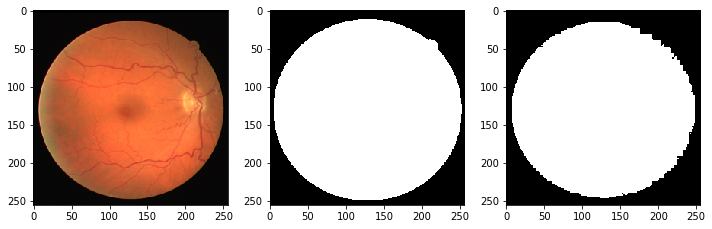

Accuracy= 0.95292664 Precision= 1.0 Recall= 0.9336802 MeanIoU= 0.89705634 DiceCoefficient= 0.9330737832060549 HD= 3.3166247903554 MyIoU= 0.7834635416666673 MAE= 0.047073364


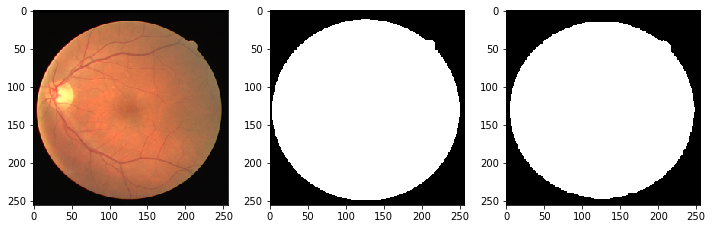

Accuracy= 0.971405 Precision= 1.0 Recall= 0.9593607 MeanIoU= 0.93568355 DiceCoefficient= 0.9521286705930834 HD= 2.8284271247461903 MyIoU= 0.8533203125000007 MAE= 0.02859497


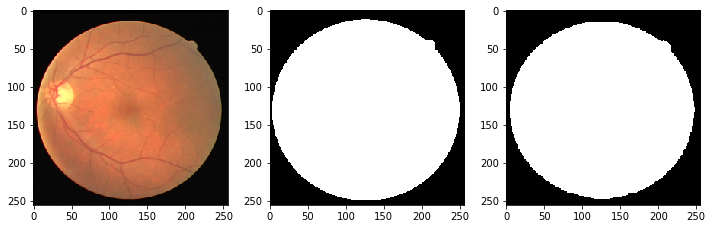

Accuracy= 0.971405 Precision= 1.0 Recall= 0.9593607 MeanIoU= 0.93568355 DiceCoefficient= 0.9521286705930834 HD= 2.8284271247461903 MyIoU= 0.8533203125000007 MAE= 0.02859497


In [175]:
x=0

xx = [1,0,0]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_train[:int(X_train.shape[0]*(1-val_split))][ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_train_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix], preds_train_t[ix])
    x = x+3

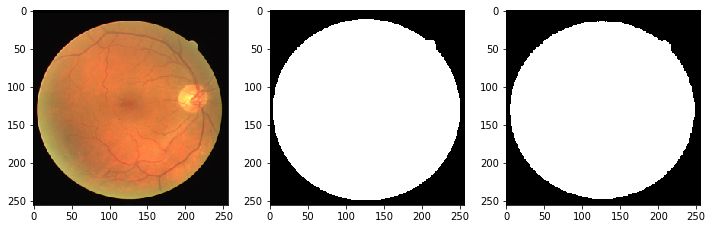

Accuracy= 0.9732361 Precision= 1.0 Recall= 0.96200585 MeanIoU= 0.9394882 DiceCoefficient= 0.9561581229063449 HD= 3.1622776601683795 MyIoU= 0.8619140625000002 MAE= 0.026763916


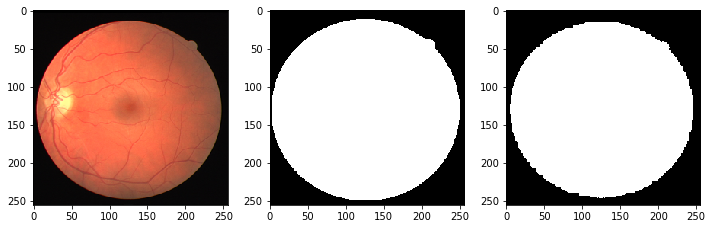

Accuracy= 0.95732117 Precision= 1.0 Recall= 0.939927 MeanIoU= 0.9057326 DiceCoefficient= 0.9366043383997749 HD= 2.8284271247461903 MyIoU= 0.8230468750000008 MAE= 0.042678833


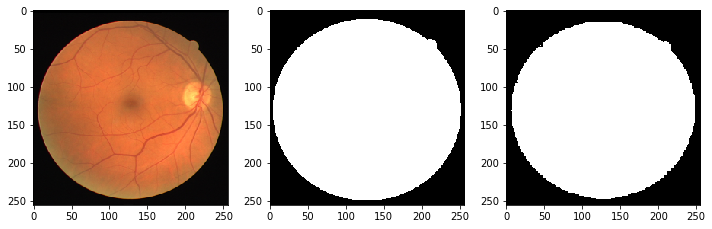

Accuracy= 0.9627533 Precision= 1.0 Recall= 0.94752455 MeanIoU= 0.916889 DiceCoefficient= 0.9463685781374807 HD= 2.6457513110645907 MyIoU= 0.8261718750000008 MAE= 0.037246704


In [176]:
x=0
xx = [16,10,15]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_test[ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_test[ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_test_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_test[ix], preds_test_t[ix])
    x = x+3
